In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.output_scroll { height:35em !important; }</style>"))

In [66]:
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt

In [58]:
import numpy as np
import tifffile as tfl
hsi_tif = tfl.TiffFile('C:/Users/konst/Documents/GitHub/Moffett-Field-labeling/data/Cuprite97/Cuprite97.tif')
hsi = hsi_tif.asarray().copy()
hsi.shape

(512, 614, 224)

In [28]:
resEmpModes, windows_size = SWEMD_signal(iSample=np.float64(hsi[100, 100]), number_of_modes=10, windows_size=6)
print(windows_size, len(windows_size))

[6, 4, 3, 3, 3, 4, 9, 10, 15, 20] 10


In [64]:
IMFs, out_windows_size = SWEMD(hsi, number_of_modes=8, windows_size=3, verbose=True)
print(IMFs.shape, out_windows_size.shape)

100%|████████████████████████████████████████████████████████████████████████| 314368/314368 [00:56<00:00, 5520.80it/s]


(8, 512, 614, 224) (8, 512, 614)


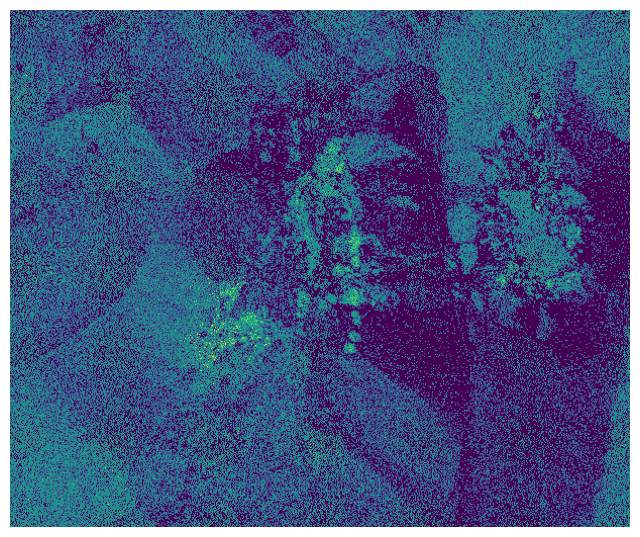

In [76]:
plt.figure(figsize=(8, 8))
plt.imshow(out_windows_size[5, ...])
plt.axis('off')
plt.show()

In [52]:
def SWEMD(data: np.ndarray, number_of_modes:int = 4, windows_size: list = [3], verbose: bool = True):
    '''
    Returns for a 1D signal its IMF and windows for each of them.

    Parameters
    ----------
    x : np.ndarray
        An array of dimension 3 (height * width * bands), dimension 2 (n_samples * bands), or just a single sample.
    number_of_modes : int, default=4
        The number of IMFs to calculate for the input signal.
    windows_size : list or tuple of int, default=3
        The size of windows for each mode, starting with the first. If the list type is passed, then each element will indicate the size of the window starting with the first IMF. 
        The list of passed sizes can be less than specified in `number_of_modes`, in which case subsequent sizes of sliding windows will be calculated automatically.
        The list can be passed a value equal to -1, in which case the window size will also be calculated automatically.
        If int is passed, this number will be the size of the sliding window only for the first IMF.
    Returns
    -------
    IMFs : list
        Non-zero value indicates error code, or zero on success.
    err_windows_size : list
        Human readable error message, or None on success.
    '''

    if data.dtype != np.float64:
        data = np.float64(data)
    
    if len(data.shape) == 3:
        height, width, bands = data.shape
        total_signals = height * width
        IMFs = np.zeros(shape=(number_of_modes, height, width, bands), dtype=np.float64)
        out_windows_size = np.zeros(shape=(number_of_modes, height, width), dtype=int)
    
        with tqdm(total=total_signals, disable=not verbose) as pbar:
            for i in range(height):
                for j in range(width):
                    IMFs[:, i, j, :], out_windows_size[:, i, j] = SWEMD_signal(iSample=data[i, j], number_of_modes=number_of_modes, windows_size=windows_size)
                    pbar.update(1)
    
    elif len(data.shape) == 2:
        n_samples, bands = data.shape
        IMFs = np.zeros(shape=(number_of_modes, n_samples, bands), dtype=np.float64)
        out_windows_size = np.zeros(shape=(number_of_modes, n_samples), dtype=int)

        for i in tqdm(range(n_samples), disable=not verbose):
            IMFs[:, i, :], out_windows_size[:, i] = SWEMD_signal(iSample=data[i], number_of_modes=number_of_modes, windows_size=windows_size)
                
    elif len(data.shape) == 1:
        IMFs, out_windows_size = SWEMD_signal(iSample=data, number_of_modes=number_of_modes, windows_size=windows_size)
        
    else:
        raise ValueError(f'It is allowed that the input array "data" has 1, 2 or 3 dimensions, but was transferred with {len(HSI.shape)} dimensions.')
        
    return IMFs, out_windows_size

In [50]:
@jit(nopython=True)
def SWEMD_signal(iSample: np.ndarray, number_of_modes: int = 4, windows_size: list = [3]):
    
    if isinstance(windows_size, int):
        windows_size = [windows_size]
    
    if windows_size[0] is None:
        windows_size[0] = 3
    windowSize = windows_size[0]
    
    sampleSize = int(iSample.shape[0])
    bound = int(windowSize / 2)
    windowSum = float(0.0)
    
    empModeSample = np.zeros(shape = sampleSize, dtype = np.float64)
    sample        = iSample.copy()
    rSample       = np.zeros(shape = sampleSize, dtype = np.float64)
    
    isDmax    = False
    isDmin    = False
    dSize     = int(sampleSize)
    dMaxCount = int(0)
    dMinCount = int(0)

    #windows_size = []
    
    resEmpModes = np.zeros(shape = (number_of_modes, iSample.shape[0]), dtype = np.float64)

    for num_imf in range(number_of_modes):
        
        #print('windowSize', windowSize)
        
        for i in range(sampleSize):
            for j in range(int(windowSize)):
                
                if (i - bound + j < 0):
                    windowSum = windowSum + sample[0]
                    continue
                
                if (i - bound + j > sampleSize - 1):
                    windowSum += sample[sampleSize - 1]
                    continue
                
                windowSum += sample[i - bound + j]
                
            rSample[i] = windowSum / windowSize
            empModeSample[i] = sample[i] - rSample[i]
            windowSum = 0.0  
            
        dSize = sampleSize
        dMaxCount = 0
        dMinCount = 0
        
        localMaxs = np.empty(shape = 0, dtype = np.int64)
        localMins = np.empty(shape = 0, dtype = np.int64)
        
        for i in range(sampleSize):
            for j in range(int(windowSize)):
                
                if (i - bound + j == i) or (i - bound + j < 0) or (i - bound + j > sampleSize - 1):
                    continue
                    
                if empModeSample[i] > empModeSample[i - bound + j]:
                    if isDmin == False:
                        isDmax = True;
                        continue
                    else:
                        isDmax = False;
                        isDmin = False;
                        break
                
                if empModeSample[i] < empModeSample[i - bound + j]:
                    if isDmax == False:
                        isDmin = True
                        continue
                    else:
                        isDmax = False
                        isDmin = False
                        break
                
                isDmax = False
                isDmin = False
                break

            if isDmax == True:
                localMaxs = np.append(localMaxs, i + 1)

            if isDmin == True:
                localMins = np.append(localMins, i + 1)

            isDmax = False;
            isDmin = False;
                
        dMaxCount = len(localMaxs)
        dMinCount = len(localMins)
        maxD = int(0)
        
        if dMaxCount >= 2:
            maxD = np.max(np.diff( localMaxs ))
            if maxD < 0: maxD = 0
                
        if dMinCount >= 2:
            maxD_min = np.min(np.diff( localMins ))
            if maxD_min < maxD: maxD = maxD_min
            
        dSize = maxD
        
        resEmpModes[num_imf] = empModeSample
        
        if len(windows_size) - 1 > num_imf:
            if windows_size[num_imf + 1] != -1:
                windowSize = windows_size[num_imf + 1]  # for next imf
            else:
                windowSize = int(2 * (dSize / 2) + 1)  # for next imf
                windows_size[num_imf + 1] = windowSize
                
        elif len(windows_size) - 1 == num_imf: 
            windowSize = int(2 * (dSize / 2) + 1)  # for next imf

        else:
            windows_size.append(windowSize)
            windowSize = int(2 * (dSize / 2) + 1)  # for next imf
            
        bound = int(windowSize / 2)
        
        #print('len(windows_size)', len(windows_size))
        #print()
        
        sample = rSample.copy()
        rSample = np.zeros(shape = sampleSize, dtype = np.float64)
    
    return resEmpModes, windows_size